In [6]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd

# Load the final datasets
ba_final = pd.read_csv(r"C:\Users\Samiksha\Downloads\BA_2New.csv")
em_final = pd.read_csv(r"C:\Users\Samiksha\Downloads\Emirates_1Newcsv")

- # Correleation Analysis:

In [47]:
# ------------------------------
# 1. Show feature names & types
# ------------------------------
print("=== British Airways Features & Types ===")
print(ba_final.dtypes)
print("\nShape:", ba_final.shape)

print("\n=== Emirates Features & Types ===")
print(em_final.dtypes)
print("\nShape:", em_final.shape)

# ------------------------------
# 2. Quick correlation with target
# ------------------------------
target = "overall_rating"

print("\n=== British Airways Correlations with Overall Rating ===")
print(ba_final.corr(numeric_only=True)[target].sort_values(ascending=False))

print("\n=== Emirates Correlations with Overall Rating ===")
print(em_final.corr(numeric_only=True)[target].sort_values(ascending=False))

=== British Airways Features & Types ===
overall_rating                  float64
review_date                      object
verified_flag                     int64
travel_class                      int64
seat_comfort                      int64
staff_service                     int64
ground_service                  float64
value_for_money                   int64
recommended                       int64
food_quality                    float64
entertainment_score             float64
wifi_score                      float64
flight_category                   int64
sentiment_score                 float64
food_sentiment                  float64
seat_sentiment                  float64
staff_sentiment                 float64
baggage_sentiment               float64
refunds_sentiment               float64
lounge_sentiment                float64
entertainment_sentiment         float64
cleanliness_sentiment           float64
airport_service_sentiment       float64
anger                           float64

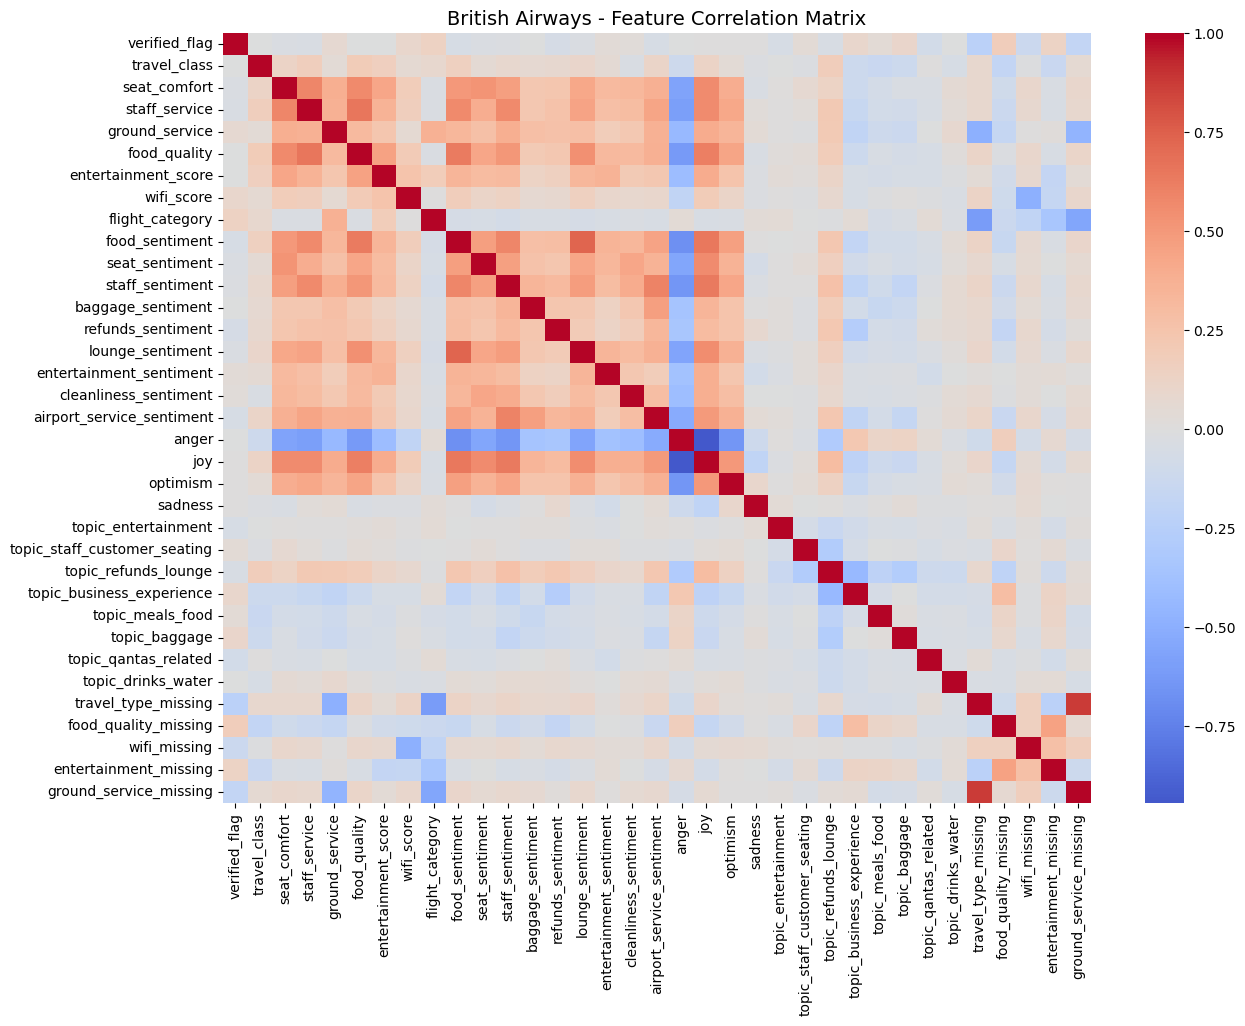

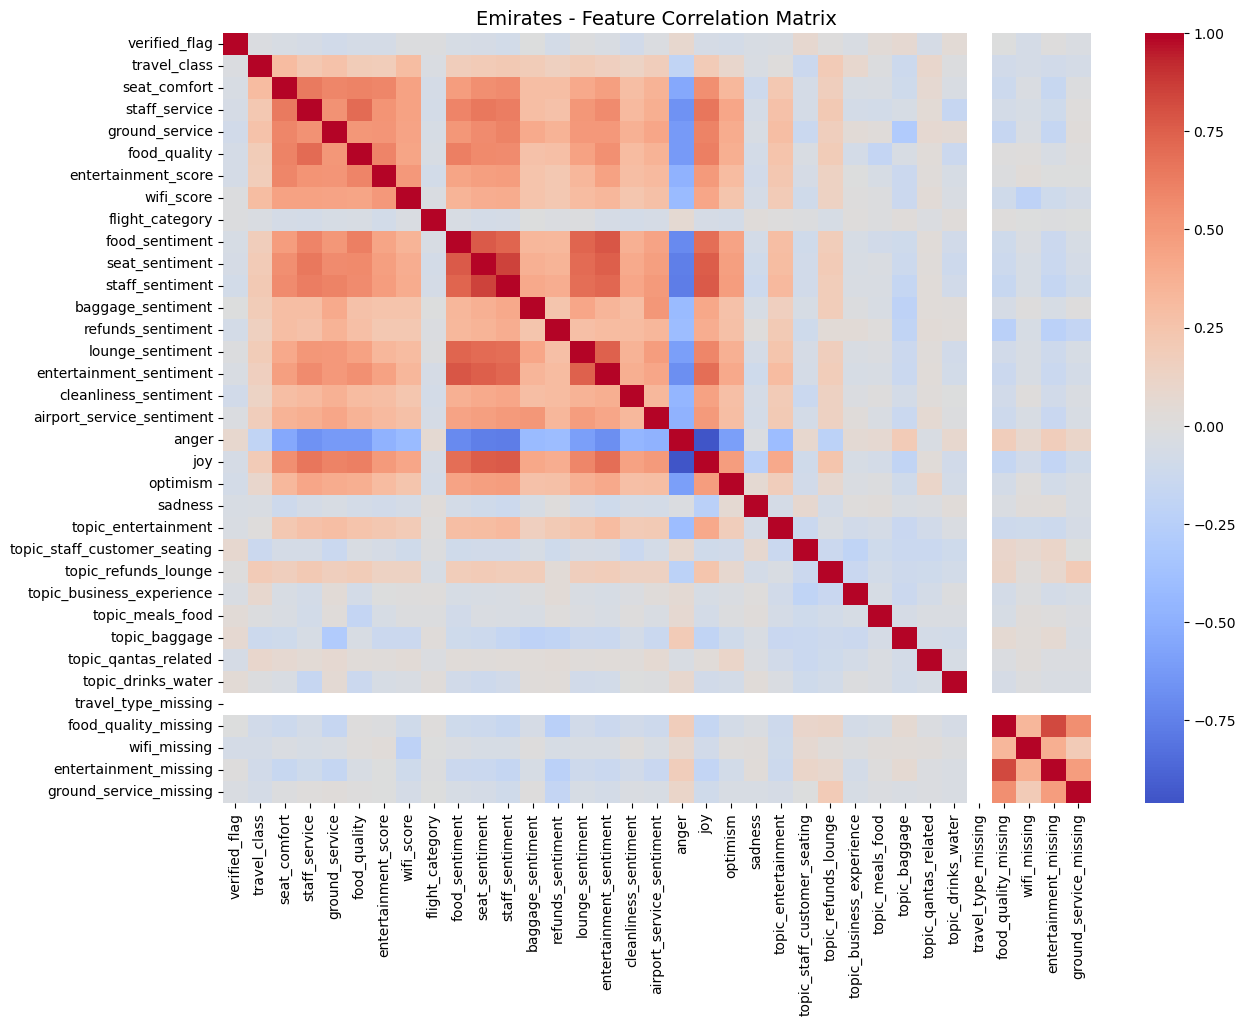


=== Top Correlated Pairs - British Airways ===
anger                joy                          0.944682
travel_type_missing  ground_service_missing       0.872032
food_sentiment       lounge_sentiment             0.733286
                     anger                        0.671246
staff_service        food_quality                 0.657496
food_sentiment       joy                          0.650265
staff_sentiment      anger                        0.646822
anger                optimism                     0.641292
staff_sentiment      joy                          0.637920
food_quality         food_sentiment               0.633143
                     anger                        0.622688
flight_category      travel_type_missing          0.617603
food_quality         joy                          0.612735
staff_sentiment      airport_service_sentiment    0.603774
staff_service        anger                        0.587700
dtype: float64

=== Top Correlated Pairs - Emirates ===
anger      

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features (drop target + leakage cols)
exclude_cols = ["overall_rating","review_date","covid_period","recommended","value_for_money","sentiment_score"]
num_feats_ba = ba_final.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=[np.number])
num_feats_em = em_final.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=[np.number])

# --- Heatmap for British Airways ---
plt.figure(figsize=(14,10))
sns.heatmap(num_feats_ba.corr(), cmap="coolwarm", center=0)
plt.title("British Airways - Feature Correlation Matrix", fontsize=14)
plt.show()

# --- Heatmap for Emirates ---
plt.figure(figsize=(14,10))
sns.heatmap(num_feats_em.corr(), cmap="coolwarm", center=0)
plt.title("Emirates - Feature Correlation Matrix", fontsize=14)
plt.show()

# --- Top correlated pairs (absolute value) ---
def top_corr_pairs(df, n=15):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = upper.stack().sort_values(ascending=False).head(n)
    return pairs

print("\n=== Top Correlated Pairs - British Airways ===")
print(top_corr_pairs(num_feats_ba, n=15))

print("\n=== Top Correlated Pairs - Emirates ===")
print(top_corr_pairs(num_feats_em, n=15))


## Seperated Data in Pre, During and Post Covid

In [61]:
import pandas as pd

# Convert review_date to datetime
ba_final["review_date"] = pd.to_datetime(ba_final["review_date"])
em_final["review_date"] = pd.to_datetime(em_final["review_date"])

# Function to tag covid period
def assign_covid_period(date):
    if date < pd.Timestamp("2020-01-01"):
        return "pre"
    elif pd.Timestamp("2020-01-01") <= date <= pd.Timestamp("2021-12-31"):
        return "during"
    else:
        return "post"

# Apply period labeling
ba_final["covid_period"] = ba_final["review_date"].apply(assign_covid_period)
em_final["covid_period"] = em_final["review_date"].apply(assign_covid_period)

# Split into separate dataframes
ba_pre = ba_final[ba_final["covid_period"] == "pre"]
ba_during = ba_final[ba_final["covid_period"] == "during"]
ba_post = ba_final[ba_final["covid_period"] == "post"]

em_pre = em_final[em_final["covid_period"] == "pre"]
em_during = em_final[em_final["covid_period"] == "during"]
em_post = em_final[em_final["covid_period"] == "post"]

# Quick sanity check
print("British Airways:", ba_pre.shape, ba_during.shape, ba_post.shape)
print("Emirates:", em_pre.shape, em_during.shape, em_post.shape)

British Airways: (2559, 46) (191, 46) (467, 46)
Emirates: (1080, 46) (153, 46) (242, 46)


## A] Model for Star Rating Prediction for British Airways [Pre,During & Post Covid Periods]

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import numpy as np
import pandas as pd

def train_rf_period(df, period_name="pre", airline="Airline"):
    if df.empty:
        print(f"No data for {airline} | {period_name}-COVID")
        return None
    
    # -----------------------------
    # Features and Target
    # -----------------------------
    X = df.drop(columns=[
        "overall_rating",     # target
        "review_date",        # timestamp
        "sentiment_score",    # redundant with aspect sentiments
        "optimism", "joy", "anger",  # emotion overlap
        "sadness", "recommended", 
        "covid_period", "value_for_money"
    ], errors="ignore")
    y = df["overall_rating"]

    # Keep only numeric features
    X = X.select_dtypes(include=["int64", "float64"])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # -----------------------------
    # Random Forest + Search
    # -----------------------------
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_dist = {
        "n_estimators": [200, 300, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"]
    }

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring="r2",
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)
    best_rf = search.best_estimator_

    # -----------------------------
    # Predictions + Metrics
    # -----------------------------
    y_pred = best_rf.predict(X_test)

    test_r2 = r2_score(y_test, y_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n=== {airline} | {period_name}-COVID ===")
    print("Best CV R²:", round(search.best_score_, 3))
    print("Test R²:", round(test_r2, 3))
    print("Test RMSE:", round(test_rmse, 3))
    print("Best Params:", search.best_params_)

    # -----------------------------
    # Permutation Importance
    # -----------------------------
    perm_importance = permutation_importance(
        best_rf, X_test, y_test, n_repeats=30, random_state=42
    )
    perm_df = pd.DataFrame({
        "feature": X_test.columns,
        "importance": perm_importance.importances_mean
    }).sort_values("importance", ascending=False)

    print("\nTop 5 Features (Permutation Importance):")
    print(perm_df.head(5))

    # -----------------------------
    # SHAP
    # -----------------------------
    explainer = shap.TreeExplainer(best_rf)
    shap_values = explainer.shap_values(X_test)

    print("\nGenerating SHAP summary plot...")
    shap.summary_plot(shap_values, X_test, show=True)

    return best_rf, search.best_params_, test_r2, test_mape, test_rmse, perm_df

- ## Pre-Covid Star Prediction Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Airline | pre-COVID ===
Best CV R²: 0.811
Test R²: 0.82
Test RMSE: 1.288
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}

Top 5 Features (Permutation Importance):
            feature  importance
2      seat_comfort    0.098133
5      food_quality    0.074457
3     staff_service    0.065227
9    food_sentiment    0.046116
11  staff_sentiment    0.038022

Generating SHAP summary plot...


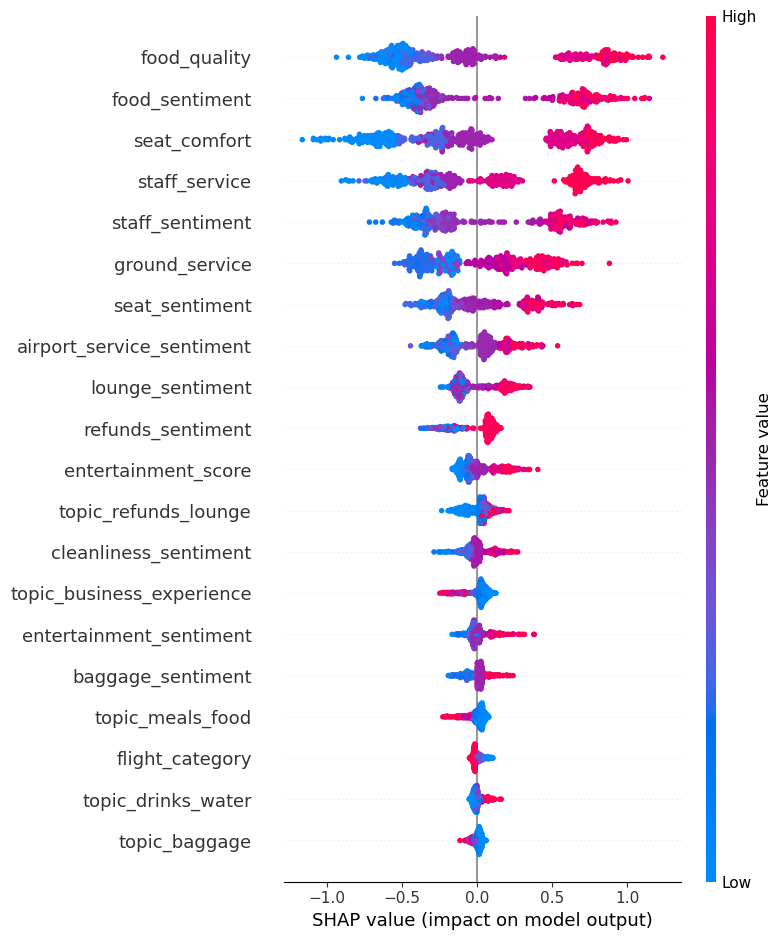

In [70]:
ba_pre_model = train_rf_period(ba_pre, "pre")

- ## During-Covid Star Prediction Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Airline | during-COVID ===
Best CV R²: 0.798
Test R²: 0.798
Test RMSE: 1.558
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}

Top 5 Features (Permutation Importance):
            feature  importance
11  staff_sentiment    0.109307
4    ground_service    0.053555
9    food_sentiment    0.051659
2      seat_comfort    0.045637
3     staff_service    0.037454

Generating SHAP summary plot...


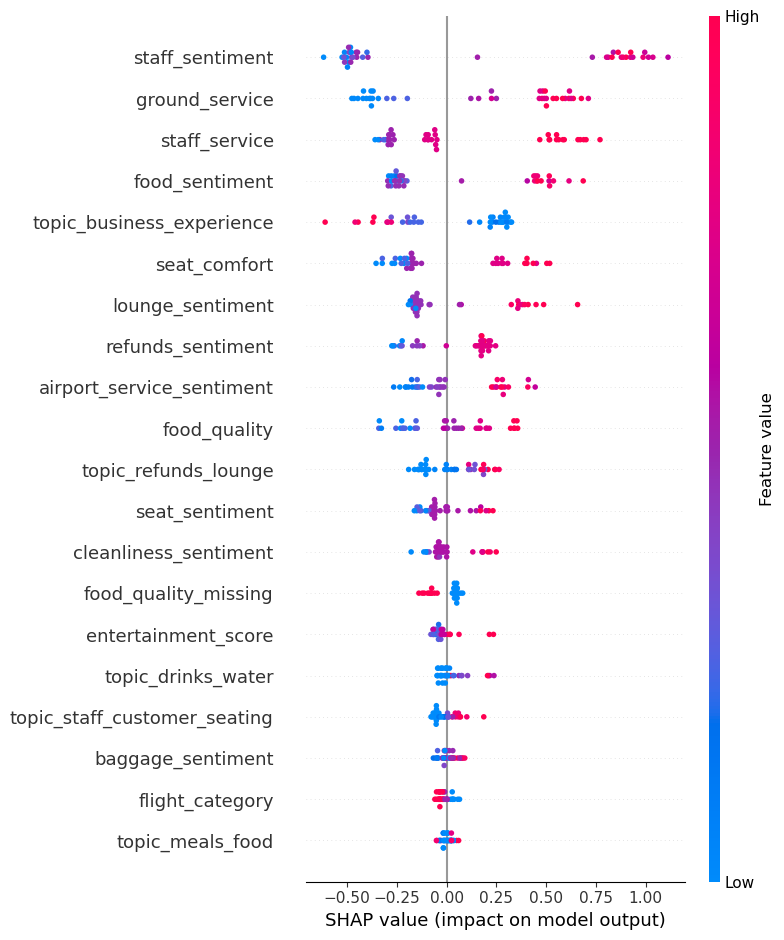

In [71]:
ba_during_model = train_rf_period(ba_during, "during")

- ## Post-Covid Star Prediction Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Airline | post-COVID ===
Best CV R²: 0.819
Test R²: 0.75
Test RMSE: 1.547
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

Top 5 Features (Permutation Importance):
                 feature  importance
4         ground_service    0.100263
2           seat_comfort    0.040847
5           food_quality    0.039818
9         food_sentiment    0.039369
20  topic_refunds_lounge    0.031189

Generating SHAP summary plot...


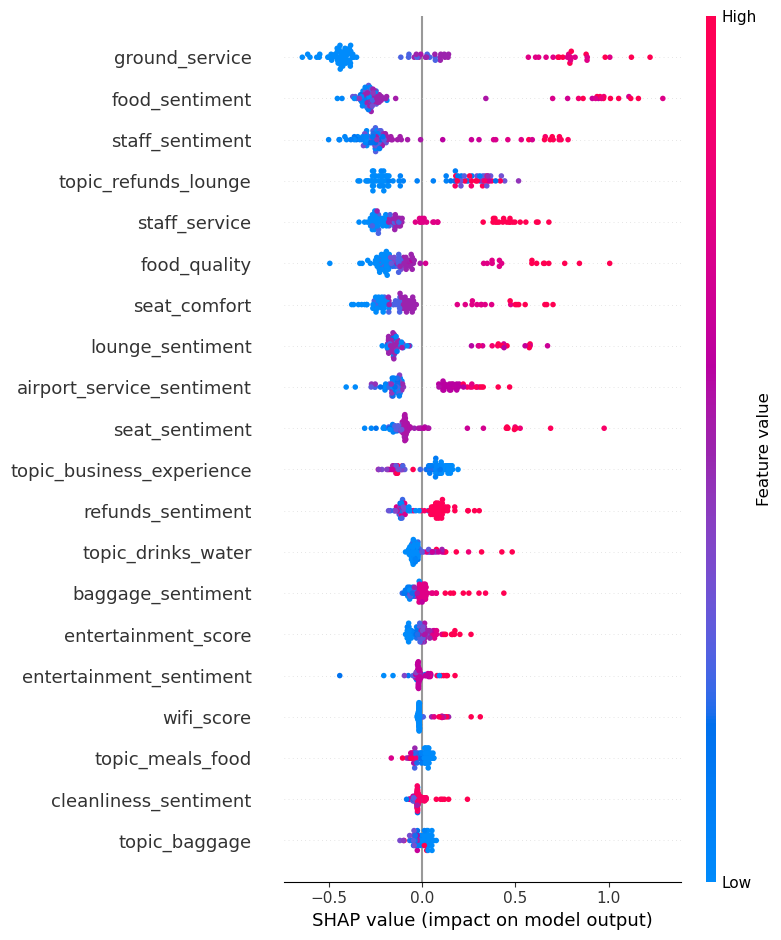

In [72]:
ba_post_model = train_rf_period(ba_post, "post")

## B] Model for Star Rating Prediction for Emirates Airlines [Pre,During & Post Covid Periods]

In [73]:
def train_rf_period(df, period_name="pre", airline="Airline"):
    if df.empty:
        print(f"No data for {airline} | {period_name}-COVID")
        return None
    
    # Drop target + leakage columns
    X = df.drop(columns=[
          "overall_rating",     # target
    "review_date",        # timestamp
    "sentiment_score",    # redundant with aspect sentiments
    "optimism",'joy','anger',           # emotion overlap
    "sadness", "recommended", "covid_period",'value_for_money'
    ], errors="ignore")
    y = df["overall_rating"]

    # Keep only numeric features
    X = X.select_dtypes(include=["int64", "float64"])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Base RF
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Hyperparameter space
    param_dist = {
        "n_estimators": [200, 300, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"]
    }

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring="r2",
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Fit on train set
    search.fit(X_train, y_train)

    # Best model
    best_rf = search.best_estimator_

    # Predict on test set
    y_pred = best_rf.predict(X_test)

    # Metrics
    test_r2 = r2_score(y_test, y_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n=== {airline} | {period_name}-COVID ===")
    print("Best CV R²:", round(search.best_score_, 3))
    print("Test R²:", round(test_r2, 3))
    print("Test MAPE:", round(test_mape, 3))
    print("Test RMSE:", round(test_rmse, 3))
    print("Best Params:", search.best_params_)

    # -----------------------------
    # Permutation Importance
    # -----------------------------
    perm_importance = permutation_importance(
        best_rf, X_test, y_test, n_repeats=30, random_state=42
    )
    perm_df = pd.DataFrame({
        "feature": X_test.columns,
        "importance": perm_importance.importances_mean
    }).sort_values("importance", ascending=False)

    print("\nTop 5 Features (Permutation Importance):")
    print(perm_df.head(5))

    # -----------------------------
    # SHAP
    # -----------------------------
    explainer = shap.TreeExplainer(best_rf)
    shap_values = explainer.shap_values(X_test)

    print("\nGenerating SHAP summary plot...")
    shap.summary_plot(shap_values, X_test, show=True)
    
    return best_rf, search.best_params_, test_r2, test_mape, test_rmse, perm_df

- ## Pre-Covid Star Prediction Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Emirates | Pre-COVID ===
Best CV R²: 0.836
Test R²: 0.831
Test MAPE: 0.403
Test RMSE: 1.31
Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}

Top 5 Features (Permutation Importance):
            feature  importance
4    ground_service    0.074462
3     staff_service    0.066925
10   seat_sentiment    0.041351
11  staff_sentiment    0.037751
5      food_quality    0.025504

Generating SHAP summary plot...


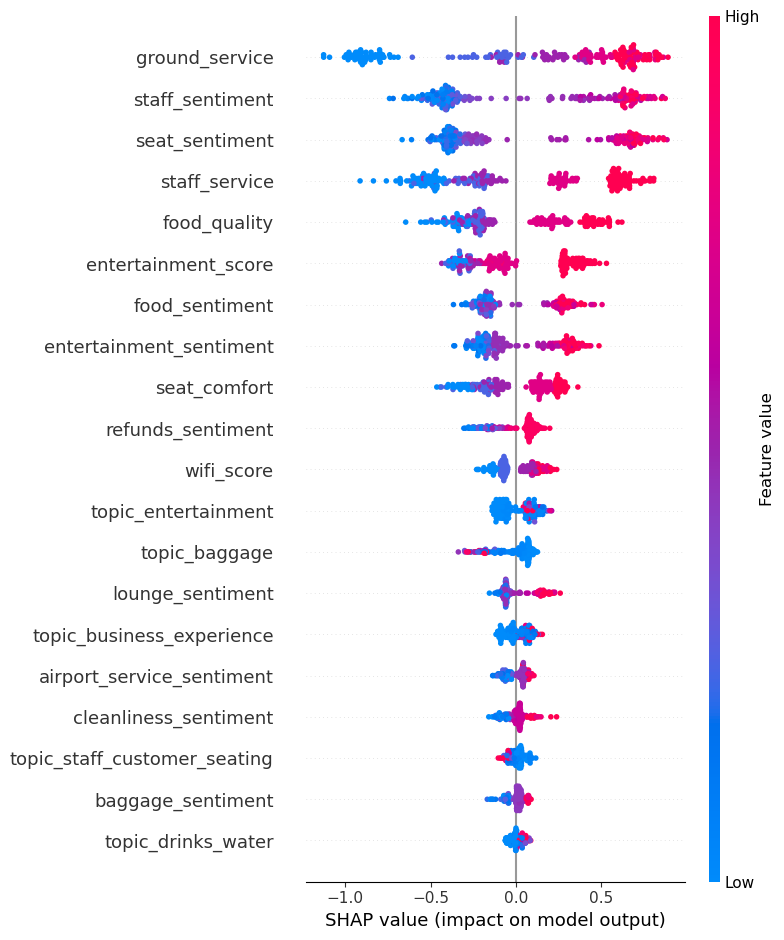

In [75]:
results_em_pre = train_rf_period(em_pre, "Pre", airline="Emirates")

- ## During-Covid Star Prediction Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Emirates | During-COVID ===
Best CV R²: 0.751
Test R²: 0.802
Test MAPE: 0.657
Test RMSE: 1.549
Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}

Top 5 Features (Permutation Importance):
                    feature  importance
4            ground_service    0.073753
15  entertainment_sentiment    0.068401
10           seat_sentiment    0.049030
5              food_quality    0.045684
11          staff_sentiment    0.045027

Generating SHAP summary plot...


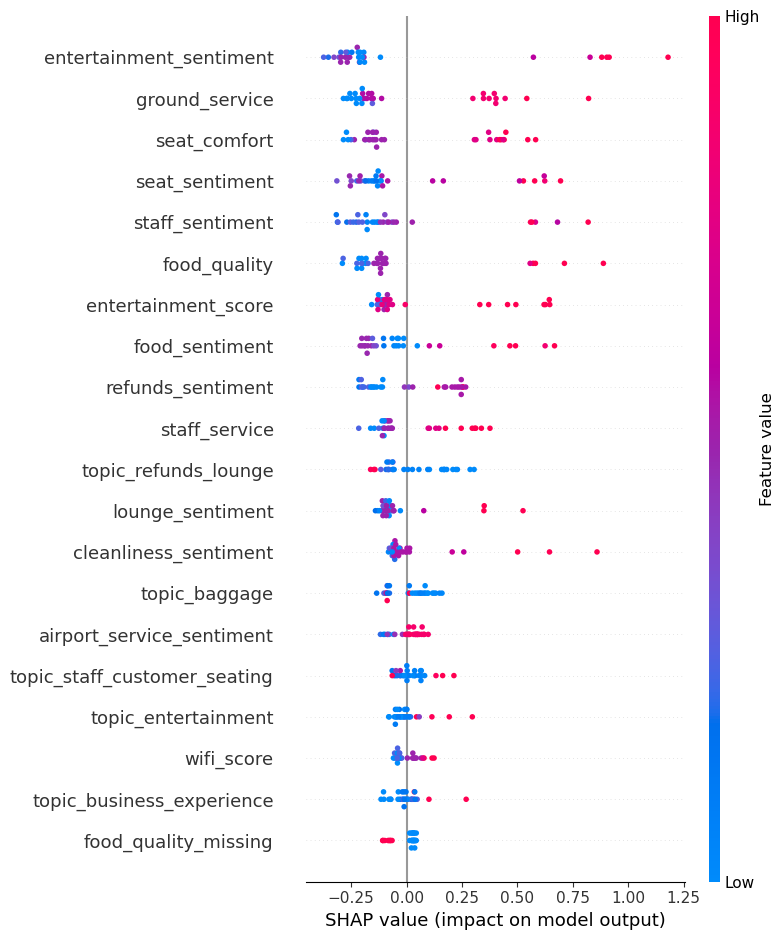

In [76]:
results_em_during = train_rf_period(em_during, "During", airline="Emirates")

- ## Post-Covid Star Prediction Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Emirates | Post-COVID ===
Best CV R²: 0.766
Test R²: 0.804
Test MAPE: 0.618
Test RMSE: 1.419
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}

Top 5 Features (Permutation Importance):
            feature  importance
4    ground_service    0.081703
11  staff_sentiment    0.074911
3     staff_service    0.065583
10   seat_sentiment    0.050579
2      seat_comfort    0.035067

Generating SHAP summary plot...


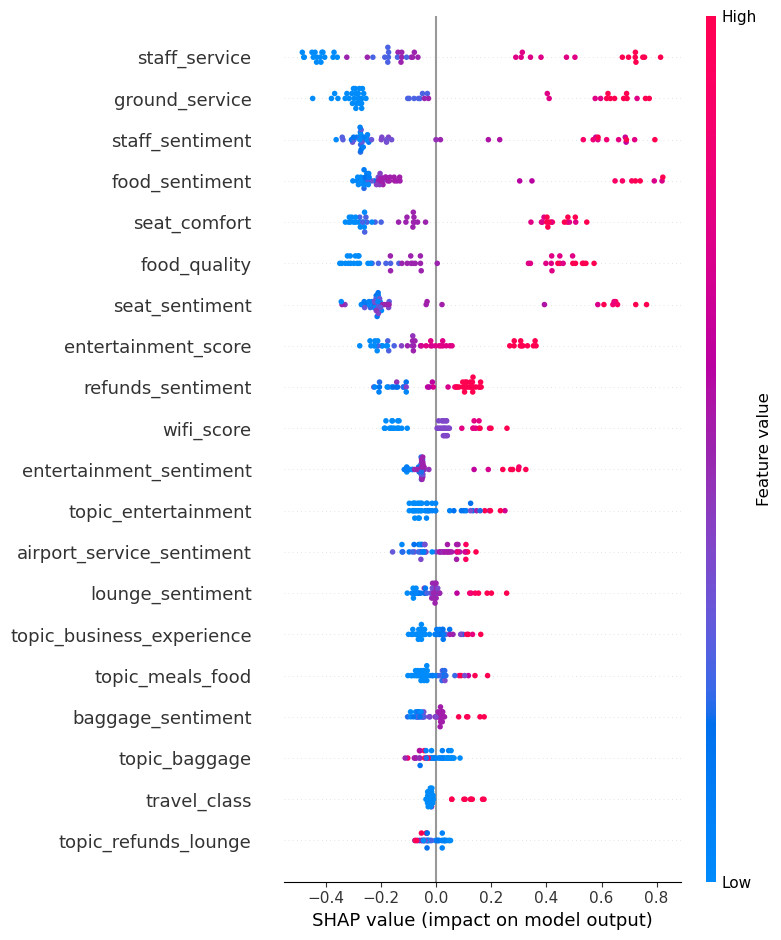

In [77]:
results_em_post = train_rf_period(em_post, "Post", airline="Emirates")